new lenet

In [ ]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
import time

mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())





  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



In [ ]:
mnist_train[0][0].shape
#mnist_train[0][0][0]
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
def load_data_fashion_mnist(mnist_train, mnist_test, batch_size):
    if sys.platform.startswith('win'):
        num_workers = 0
    else:
        num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(mnist_train, mnist_test, batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5 ,padding = 0,bias = False), # in_channels, out_channels, kernel_size
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # kernel_size, stride
            nn.Conv2d(6, 16, kernel_size=5 ,padding = 0,bias = False),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, img):
        feature = self.conv(img)
        # return feature
        output = self.fc(feature.view(img.shape[0], -1))
        return output




net = LeNet()




In [ ]:
class LeNet1(nn.Module):
    def __init__(self):
        super(LeNet1, self).__init__()
        
        self.conv1 =nn.Conv2d(1, 6, kernel_size=5 ,padding = 0,bias = False) # in_channels, out_channels, kernel_size
        self.relu =nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2) # kernel_size, stride
        self.conv2 =  nn.Conv2d(6, 16, kernel_size=5 ,padding = 0,bias = False)
            
            
        
        self.layer1 = nn.Linear(16*4*4, 120)
            
        self.layer2 = nn.Linear(120, 84)
            
        self.layer3 = nn.Linear(84, 10)
        

    def forward(self, img):
        feature = self.conv1(img)
        feature = self.relu(feature)
        feature = self.maxpool(feature)
        feature = self.conv2(feature)
        feature = self.relu(feature)
        feature = self.maxpool(feature)

        

        feature = feature.view(img.shape[0],-1)
        
        feature = self.layer1(feature)
        
        feature = self.relu(feature)
                         #此时没有问题
        feature = self.layer2(feature)
        
        feature = self.relu(feature)
        # return feature
        feature = self.layer3(feature)
        
        return feature
        




net1 = LeNet1()

In [ ]:
for name, parameters in net1.named_parameters():
    print(name, ':', parameters.size())

conv1.weight : torch.Size([6, 1, 5, 5])
conv2.weight : torch.Size([16, 6, 5, 5])
layer1.weight : torch.Size([120, 256])
layer1.bias : torch.Size([120])
layer2.weight : torch.Size([84, 120])
layer2.bias : torch.Size([84])
leyer3.weight : torch.Size([10, 84])
leyer3.bias : torch.Size([10])


In [ ]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    return acc_sum / n


def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))


In [ ]:
lr, num_epochs = 0.001, 20
optimizer = torch.optim.Adam(net1.parameters(), lr=lr)
train(net1, train_iter, test_iter, batch_size, optimizer, device, num_epochs)

training on  cuda


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1, loss 0.9509, train acc 0.658, test acc 0.757, time 10.2 sec
epoch 2, loss 0.5596, train acc 0.788, test acc 0.799, time 10.2 sec
epoch 3, loss 0.4864, train acc 0.823, test acc 0.824, time 10.3 sec
epoch 4, loss 0.4385, train acc 0.843, test acc 0.841, time 10.3 sec
epoch 5, loss 0.4027, train acc 0.855, test acc 0.849, time 10.3 sec
epoch 6, loss 0.3764, train acc 0.865, test acc 0.862, time 10.4 sec
epoch 7, loss 0.3550, train acc 0.871, test acc 0.862, time 10.2 sec
epoch 8, loss 0.3411, train acc 0.877, test acc 0.865, time 10.3 sec
epoch 9, loss 0.3246, train acc 0.883, test acc 0.870, time 10.4 sec
epoch 10, loss 0.3175, train acc 0.884, test acc 0.873, time 10.4 sec
epoch 11, loss 0.3046, train acc 0.890, test acc 0.881, time 10.3 sec
epoch 12, loss 0.2956, train acc 0.893, test acc 0.884, time 10.3 sec
epoch 13, loss 0.2896, train acc 0.896, test acc 0.882, time 10.4 sec
epoch 14, loss 0.2828, train acc 0.897, test acc 0.881, time 10.4 sec
epoch 15, loss 0.2760, train 

In [ ]:

for name in net1.state_dict():
  print(name)


conv1.weight
conv2.weight
layer1.weight
layer1.bias
layer2.weight
layer2.bias
layer3.weight
layer3.bias


In [ ]:
np.set_printoptions(threshold=40000) # 这个参数填的是你想要多少行显示
np.set_printoptions(linewidth=40000) # 这个参数填的是横向多宽
device = torch.device("cpu")
model = net1.to(device)

conv0w = net1.state_dict()['layer2.weight']
conv0w
import scipy.io as io
result1 = np.array(conv0w)
result1
# np.savetxt('conv0w.txt',result1)
# io.savemat('save.mat',{'result1':result1})

array([[ 4.49050628e-02, -1.14272393e-01,  5.30746579e-02,  8.10936093e-02,  5.56140058e-02, -5.80167957e-02, -1.16299996e-02,  1.23432055e-01,  1.65100396e-01,  5.93842044e-02,  7.83380568e-02,  7.65663683e-02,  9.61995870e-02,  9.97336954e-02,  1.39845833e-01,  8.07263255e-02,  1.15719862e-01, -3.79018784e-02, -1.88316554e-02,  4.86087166e-02, -6.01243749e-02, -1.02964593e-02,  3.02910693e-02,  2.90939864e-02,  7.98970386e-02, -2.60324240e-01, -6.33301288e-02, -1.46105692e-01,  9.82739218e-03,  1.06626853e-01,  4.96130437e-02, -9.74108204e-02,  6.19716384e-02,  1.81947947e-01, -5.38141504e-02, -2.10400354e-02, -1.00629896e-01, -3.41620184e-02,  3.85741405e-02,  2.72129979e-02, -1.07320715e-02, -1.54563561e-02, -4.46688682e-02, -6.56133592e-02, -2.55498216e-02,  2.50062067e-02, -1.56529009e-01,  4.28954363e-02, -2.18939520e-02, -1.83290064e-01, -2.35558627e-03,  1.00051671e-01, -9.35611576e-02,  1.11593723e-01,  2.19471589e-01, -1.72378853e-01, -9.78935882e-02,  4.26910892e-02,  1.713

In [ ]:
x = mnist_train[2][0]
y = mnist_train[2][1]
x = x.unsqueeze(0)
x.shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = x.to(device)
predict = net(x)
x


RuntimeError: ignored

In [ ]:

#保存
torch.save(net1, "mylenet2.pt")
#读取
the_model = torch.load(PATH)


NameError: ignored

读取和解析本地模型文件

In [ ]:
import pandas as pd
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


conv0w = net.state_dict()['fc.0.weight']
torch.save(conv0w,'fc0w.pth')
np.save("fc0w.npy",conv0w)

loadData = np.load('fc0w.npy')

print("----type----")
print(type(loadData))
print("----shape----")
print(loadData.shape)
print("----data----")
print(loadData)


In [ ]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
import time

#读取
net1 = torch.load("/content/sample_data/mylenet2.pt")
print(next(net1.parameters()).device)
mnist_train[0][0].shape
#mnist_train[0][0][0]
x = mnist_train[0][0]
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# x = x.to(device)
x = x.unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x=x.to(device)
predict = net1(x)
predict


cuda:0


tensor([[ -9.3173,  -9.6652, -10.2977,  -8.5448, -16.4153,  -0.4628, -10.3211,
           7.6204,  -2.8877,  12.6351]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

torch.Size([60000, 28, 28])
torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


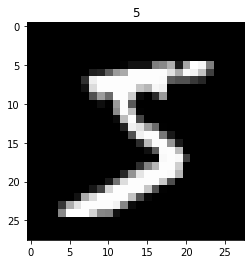

RNN(
  (rnn): RNN(28, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
)


ValueError: ignored